# Astrometry Response functions (Maps)

In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib
from matplotlib import colormaps
import matplotlib.pyplot as plt
import healpy as hp
import itertools
import os

In [2]:
# Conversion between b and \theta
v_theta = (np.pi/2)-np.radians(48) # (pi/2 - b) E[0,pi]
v_phi = np.radians(264) # l E[0,2pi]

In [3]:
# unit vector in R3. 
#Given two angles, \theta E[0,pi] and \phi E[0,2pi], the next function returns its cartesian coordinates
def skyvec(theta,phi): 
    st = np.sin(theta)
    cp = np.cos(phi)
    sp = np.sin(phi)
    ct = np.cos(theta)
    return np.array([st*cp,st*sp,ct])

print(skyvec(2,3))
print(np.dot(skyvec(2,3),skyvec(2,3)))

[-0.90019763  0.12832006 -0.41614684]
1.0


## Uniform stars and fixed velocity

In [4]:
def vecdot(a,b): # (N,3) vectors
    a = np.atleast_2d(a)
    b = np.atleast_2d(b)
    dot = np.sum(a*b,axis=0)
    return dot
    
#a=[[0,1,2],[3,4,5],[6,7,8],[9,10,11]]
#b=[[0,1,1]]
#adotb=vecdot(a,b)
#print(adotb)

def hola(y):
    return np.where(y == 0, 0, np.log(y))    
#print(hola(2))

def F0(v,n1,n2):
    cos_zeta = vecdot(n1,n2)
    y = (1- cos_zeta)/2
    num = np.pi*(1- 8*y +7*(y**2) - 6*(y**2)*hola(y))
    den = 3* ((1-y)**2)
    return num/den

def F1(v,n1,n2):
    cos_zeta = vecdot(n1,n2)
    y = (1- cos_zeta)/2
    num = -np.pi*(2*y -1) *((y-1)*(2*y +1) - 3*y*hola(y))
    den = 6*((y-1)**3)
    return num/den

def F2(v,n1,n2):
    cos_zeta = vecdot(n1,n2)
    y = (1- cos_zeta)/2
    num = np.pi*y*((y-1)*(2*y +1) - 3*y*hola(y))
    den = 3*((y-1)**2)
    return num/den

def TraceGTanalytic_H1_ij(v, n1, n2):
    y = (1-vecdot(n1,n2))/2 
    n1v = vecdot(n1,v)
    n2v = vecdot(n2,v)
    n1n2 = vecdot(n1,n2)
    factor = 2*(n1v+n2v)/n1v
    t1 = - F2(v,n1,n2)*(n1v + n2v - 2*n1v*y)
    t2 = F1(v,n1,n2)*(n1v - n2v)*( 1 + 6*(y-1)*y + n1n2*(2*y -1))/(2*y -1)
    return (t1+t2)*factor


## Changing the color of the map according to a function

In [5]:
np.random.seed(5)
random_vector = np.random.randn(3)
unit_vector = random_vector / np.linalg.norm(random_vector)

print(unit_vector)
print(np.dot(unit_vector,unit_vector))

[ 0.17701851 -0.13274364  0.97521463]
1.0


dir shape: (3, 12288)
v shape: (3, 1)
vm shape: (3, 1)
vn [2.40855437] [1.46607657]
v [[-0.06994319]
 [-0.66546504]
 [ 0.74314483]]
[-0.10373997 -0.11606031 -0.12026848 ...  0.14434274  0.14013457
  0.12613467]
min: nan
max: nan


/var/folders/19/x89tx7bs1ldf399fhwg8hn7w0000gq/T/ipykernel_955/3954038385.py:44: RuntimeWarning: invalid value encountered in divide
  t2 = F1(v,n1,n2)*(n1v - n2v)*( 1 + 6*(y-1)*y + n1n2*(2*y -1))/(2*y -1)


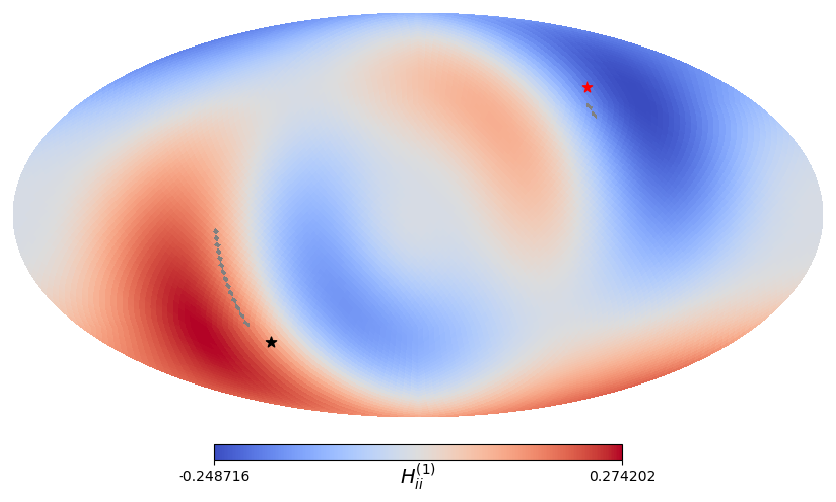

In [6]:
nside = 32 # 
npix = hp.nside2npix(nside)
theta, phi = hp.pix2ang(nside, np.arange(npix))
dir = skyvec(theta,phi) #.T#.reshape(npix,3)

######### Ameek's values #########
theta1, phi1 = (np.pi/2,0)
n1 = skyvec(theta1,phi1).reshape(3,1)

theta0 = np.deg2rad(48) 
phi0 = np.deg2rad(264)
# vvec = np.array([0,0,1])
vvec = skyvec(theta0,phi0).reshape(3,1)
##################################

v = skyvec(v_theta, v_phi).reshape(3,1)
#vn = skyvec(theta0,phi0).reshape(3,1)
#vn = skyvec(v_theta, v_phi).reshape(3,1) # Same direction as velocity 
#vn = skyvec(v_theta, v_phi+0.1).reshape(3,1) # Close to the velocity
vn = -1.*np.array(v) # Opposite to the velocity
#vn = unit_vector.reshape(3,1) # Random position
vs = -1.*np.array(v)
thetaVn, phiVn = hp.vec2ang(vn)
thetaVs, phiVs = hp.vec2ang(vs)


print('dir shape:',np.shape(dir))
print('v shape:',np.shape(v))
print('vm shape:',np.shape(vn))
print('vn',thetaVn, phiVn)
print('v', v)

Map_TraceHij_1=TraceGTanalytic_H1_ij(v, dir, n1)

print(Map_TraceHij_1)

hp.mollview(Map_TraceHij_1,title=r'',cmap='coolwarm',cbar=True, unit=r'$H^{(1)}_{ii}$')
hp.projscatter(v_theta,v_phi,marker='*',s=60,color='r')
hp.projscatter(thetaVn,phiVn,marker='*',s=60,color='k')
#hp.projscatter(thetaVn, phiVn,marker='*',s=30,color='k'#),coord=['E','G'])

min = np.min(Map_TraceHij_1)
max = np.max(Map_TraceHij_1)
print('min:',min)
print('max:',max)

[ 0.32511979  0.32570301  0.32938961 ... -0.04840505 -0.05659135
 -0.0557155 ]
min: -0.1984849126850923
max: 0.32986615559322974


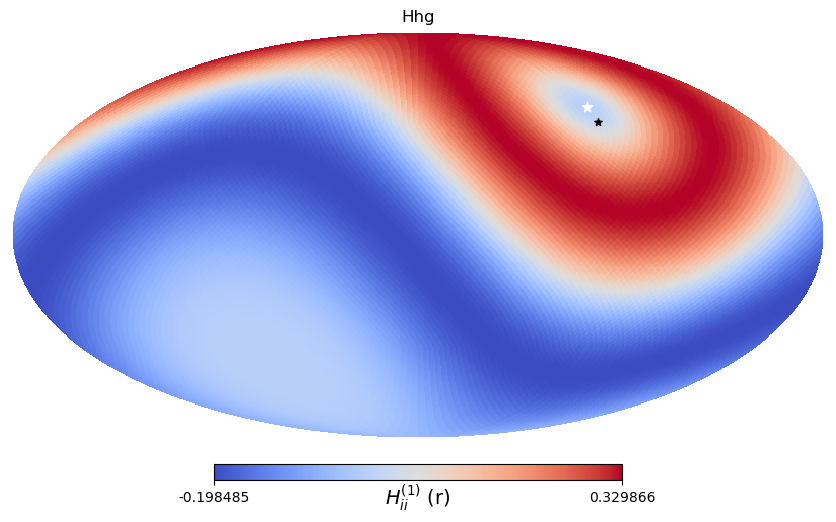

In [12]:
######### Ameek's values #########
theta2 = np.deg2rad(48.5) 
phi2 = np.deg2rad(264.5)
n2 = skyvec(theta2,phi2).reshape(3,1)

theta0 = np.deg2rad(48) 
phi0 = np.deg2rad(264)
vvec = skyvec(theta0,phi0).reshape(3,1)
##################################

vn2 = np.array(v)
thetaVn2, phiVn2 = hp.vec2ang(vn2)

TraceHij_random = TraceGTanalytic_H1_ij(v, dir, vn2)
print(TraceHij_random)
min = np.min(TraceHij_random)
max = np.max(TraceHij_random)
print('min:',min)
print('max:',max)

hp.mollview(TraceHij_random,title=r'Hhg',cmap='coolwarm',cbar=True, unit=r'$H^{(1)}_{ii}$ (r)')
#hp.projscatter(theta0,phi0,marker='*',s=60,color='r')#,coord=['E','G'])
hp.projscatter(thetaVn2, phiVn2,marker='*',s=60,color='w')
hp.projscatter(theta0, phi0,marker='*',s=30,color='k')#,coord=['E','G']) 

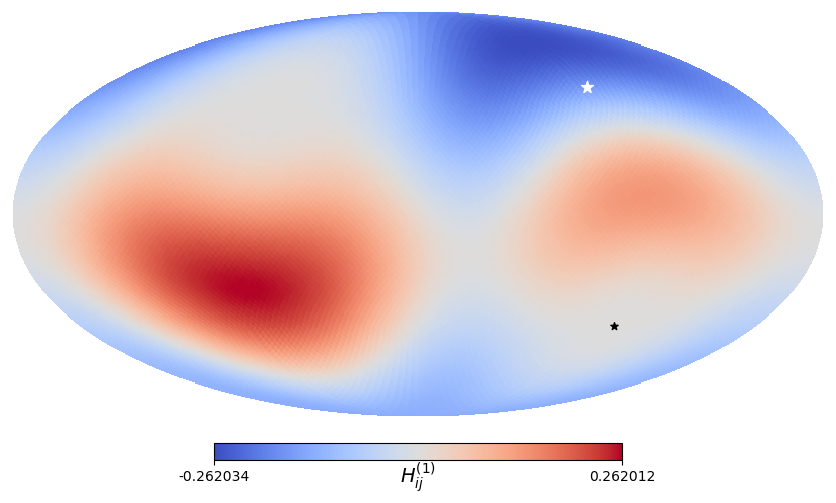

In [8]:
v_orth = np.array([-0.18639486, -0.72313051, -0.66508587]).reshape(3,1)
theta_Ort, phi_Ort = hp.vec2ang(v_orth)

MapOrth_H1_ij = TraceGTanalytic_H1_ij(v, dir, v_orth)

hp.mollview(MapOrth_H1_ij,title=r'',cmap='coolwarm',cbar=True, unit=r'$H^{(1)}_{ij}$')
hp.projscatter(v_theta, v_phi,marker='*',s=80,color='w')
hp.projscatter(theta_Ort, phi_Ort,marker='*',s=30,color='k')#,coord=['E','G']) 